# **Bag of words classification: Week 2**

## Team 8
Members:
- **Hicham El Muhandiz Aarab**
- **Julia Ariadna Blanco Arnaus**

## Introduction
In this project we try to classify MIT dataset images into their correct class using the Bag of Visual Words model. We extract the features from the images, and we agreggate them. Then, we train a classifier to output the label corresponding to the image category.



Let's import the required libraries for the project

In [ ]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.pyplot as plt
import optuna

from optuna.visualization import plot_contour
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances
from IPython.display import display
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

In [ ]:
#install opencv version that allows using sift
!pip install opencv-contrib-python==4.4.0.44
#install optuna
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#load database from drive
from google.colab import drive
drive.mount('/content/drive')
filepath = './drive/My Drive'


#load database locally
#filepath = '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let us first read the train and test files

In [ ]:
def read_files():
    train_images_filenames = pickle.load(open(filepath+'/MIT_split/'+'train_images_filenames.dat','rb'))
    test_images_filenames = pickle.load(open(filepath+'/MIT_split/'+'test_images_filenames.dat','rb'))
    train_images_filenames = [filepath + n[15:] for n in train_images_filenames]
    test_images_filenames  = [filepath + n[15:] for n in test_images_filenames]
    train_labels = pickle.load(open(filepath+'/MIT_split/''train_labels.dat','rb')) 
    test_labels = pickle.load(open(filepath+'/MIT_split/''test_labels.dat','rb'))

    return train_images_filenames, test_images_filenames, np.asarray(train_labels), test_labels

In [ ]:
train_images_filenames[12]

'./drive/My Drive/MIT_split/train/Opencountry/fie26.jpg'

Let's visualize the images in the the dataset:




Training set
Number of samples: 1881


Testing set
Number of samples: 807


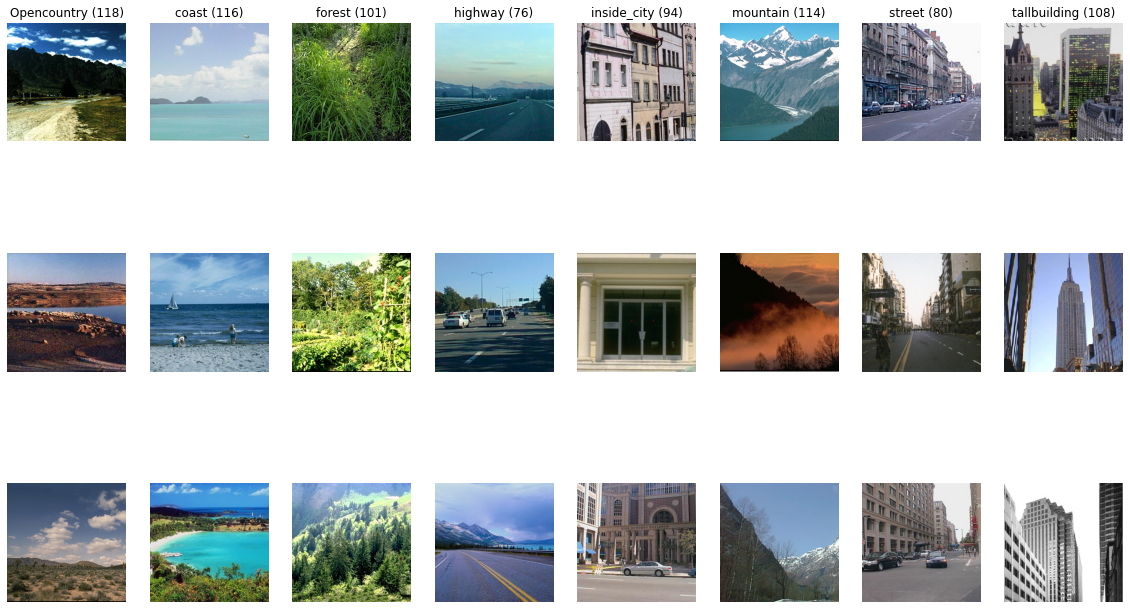

In [ ]:
def plot_dataset(image_filenames, labels, samples=3):

    print(f'Number of samples: {len(image_filenames)}')
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(20,12))
    
    for i, clase in enumerate(classes):
        indices = np.where(np.array(labels) == clase)[0]
        random_indices = np.random.choice(indices, samples, replace=False)
        for j, index in enumerate(random_indices):
            plt_idx = j * num_classes + i + 1
            plt.subplot(samples, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[index]))
            plt.axis('off')
            if j == 0:
                plt.title(f'{clase} ({len(indices)})')
    plt.show()

#For the training set
print('Training set')
plot_dataset(train_images_filenames, train_labels, 3)

#For the testing set
print('Testing set')
plot_dataset(test_images_filenames, test_labels, 3)

Let's start by creating a KAZE/SIFT/.... object detector and descriptor

We compute the  descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [ ]:
def get_descriptors(trial, train_images_filenames, spatial_pyramid=None):
    
    Train_descriptors = []
    Train_label_per_descriptor = []
    spatial_pyramid = True
    max_features = 2000
    step_size = trial.suggest_int('stepsize', 8, 16, step=4)
    octaves = trial.suggest_int('octaves', 4, 32, step=8)
    Detector = cv2.SIFT_create(nfeatures=max_features, nOctaveLayers=octaves)
    for filename, labels in zip(train_images_filenames, train_labels):
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        if spatial_pyramid:
            max_level = trial.suggest_int('max_level', 1, 2)
            horizontal = trial.suggest_categorical('hor_only', [True, False])
            des = compute_spatial_pyramid_representation(gray, Detector, max_level, step_size, horizontal)
        else:
            des = compute_keypoints_step(gray, Detector, step_size)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)
    return Train_descriptors


def compute_spatial_pyramid_representation(image: np.ndarray, Detector, max_level, step_size, hor_only, vary_scale = True) -> np.ndarray:
    """Recursively calculates block based histogram based on its level, and then concatenates them

        color_space: if GRAYSCALE is selected it will compute the 1d grayscale histogram. If color_space contains "HSV", "BGR", "YCBCR" or "LAB" it will
            compute the concatenated HSV/BGR/YCBCR/LAB histogram
        nbins: # of bins of the resultant histogram
        level: defines in how many blocks will be splitted the image. For example, setting level 4 will split the image in 16 blocks
    """
    histogram_level_list = []
    descriptors = compute_keypoints_step(image,Detector, step_size)
    histogram_level_list.append(descriptors)
    sequence = 2

    while sequence <= max_level:
        if vary_scale:
                step_size= round(step_size/2)
        histogram_level_list.append(
            compute_block_based_histogram(image, Detector, sequence, step_size, hor_only))
        sequence *= 2

    return np.concatenate(histogram_level_list, axis=0)

    


def compute_block_based_histogram(image: np.ndarray, Detector,  level, step_size, hor_only) -> np.ndarray:
    """Divides image in non-overlapping blocks, first splits image vertically, and then horizontally. For each block, computes its histogram, and then concatenates them.
        color_space: if GRAYSCALE is selected it will compute the 1d grayscale histogram. If color_space contains "HSV", "BGR", "YCBCR" or "LAB" it will
            compute the concatenated HSV/BGR/YCBCR/LAB histogram
        nbins: # of bins of the resultant histogram
        level: defines in how many blocks will be splitted the image. For example, setting level 4 will split the image in 16 blocks
    """

    image_blocks = []
    histogram_block_list = []
    hor_only = False
    if not hor_only:
        # Split image vertically
        image_vertically_splitted = np.array_split(image, level, axis=0)

    
    # Split each block of the image horizontally
    for i in image_vertically_splitted:
        image_blocks.extend(np.array_split(i, level, axis=1))

    for image_block in image_blocks:
        histogram_block_list.append(
            compute_keypoints_step(image_block, Detector, step_size))

    # Concatenate histograms
    return np.concatenate(histogram_block_list, axis=0)



def compute_keypoints_step (gray_image, Detector, step_size=20):
    """Computes the dense sift of an image given a step size
          gray_image: 1 channel image (grayscale)
          step_size = 
    """
    # compute keypoints using patches of the step size
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray_image.shape[0], step_size)
          for x in range(0, gray_image.shape[1], step_size)]

    _, des = Detector.compute(gray_image, kp)
    return des


We now compute a k-means clustering on the descriptor space and we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word. Descriptors are normalzied

In [ ]:
def normalize_visual_words(trial, visual_words):
    norm = trial.suggest_categorical('norm', ['l2', 'power', 'scaler'])
    if norm == 'l2':
        return normalize(visual_words, norm='l2')
    elif norm == 'power':
        return visual_words/np.sum([visual_words], axis=-1).reshape(visual_words.shape[0], -1)
    elif norm == 'scaler':
        return StandardScaler().fit_transform(visual_words)

def compute_visual_words(trial, Train_descriptors, Test_descriptors):
    print("compute visual words")
    k = trial.suggest_categorical("codebook", [128, 256, 512])
    D = np.vstack(Train_descriptors)
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=42)
    codebook.fit(D)

    visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words = codebook.predict(Train_descriptors[i])
        visual_words[i, :] = np.bincount(words, minlength=k)

    visual_words_test = np.zeros((len(Test_descriptors), k), dtype=np.float32)
    for i in range(len(Test_descriptors)):
        words = codebook.predict(Test_descriptors[i])
        visual_words_test[i, :] = np.bincount(words, minlength=k)

    visual_words = normalize_visual_words(trial, visual_words)
    visual_words_test = normalize_visual_words(trial, visual_words_test)

    return visual_words, visual_words_test

We first reduce the dimensionality of the data. 

In [ ]:
def dimensionality_reduction(trial, X_train, y_train, X_validate):
    dimensionality_reduction = trial.suggest_categorical("technique", ['PCA', 'LDA'])
    n_components = trial.suggest_categorical("n_components", range(2, 8))
    if dimensionality_reduction == 'PCA':
        pca = PCA(n_components=n_components)
        X_train_DR = pca.fit_transform(X_train)
        X_validate_DR = pca.transform(X_validate)
    elif dimensionality_reduction == 'LDA':
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        X_train_DR = lda.fit_transform(X_train, y_train)
        X_validate_DR = lda.transform(X_validate)

    return X_train_DR, X_validate_DR


And we fit the data by using KNN or SVM

In [ ]:
def hist_intersection(X, Y):
        """Given two histograms, computes the histogram intersection
            histogram1, histogram2: histograms of the images to compare the similarities of
        Output: histogram intersection
            """
        histogram_intersection = np.sum(np.minimum(X, Y))
        return histogram_intersection

def fit_data(trial, visual_words, train_labels, visual_words_test):
    print("fit data")
    classifier = trial.suggest_categorical("classifier", ['SVM', 'KNN'])
    labels_test = None
    if classifier == 'SVM':
        # svc_kernels
        kernel = trial.suggest_categorical(
            "kernel_parameters", ['linear', 'poly', 'rbf', 'sigmoid'])
        svc = svm.SVC(kernel=kernel)
        svc.fit(visual_words, train_labels)
        labels_test = svc.predict(visual_words_test)
    elif classifier == 'KNN':
        n_neighbours = trial.suggest_int("n_neighbours", 1, 32)
        knn_metric = trial.suggest_categorical(
            "knn_metric", ["cosine", "euclidean", "manhattan"])
        knn = KNeighborsClassifier(n_neighbors=n_neighbours, metric=knn_metric)
        knn.fit(visual_words, train_labels)
        labels_test = knn.predict(visual_words_test)

    return labels_test


Finally, with Optuna we run 50 trials to test the different hyperparameters

In [ ]:
#Picked code from Team 10
def objective(trial):
    """Average accuracy estimations across cross-validation folds"""
    # Define the cross-validation scheme
    kf = KFold(n_splits=5, shuffle=True)
    folds = list(kf.split(train_images_filenames))
    Descriptors = get_descriptors(trial, train_images_filenames)
    # to be able to access via multi-index
    Descriptors = np.asarray(Descriptors)
    is_first_fold = True
    scores = []
    for fold in folds:
        descriptor_train, label_train = Descriptors[fold[0]], train_labels[fold[0]]
        descriptor_validate, label_validate = Descriptors[fold[1]], train_labels[fold[1]]
        visual_words_train, visual_words_validate = compute_visual_words(trial, descriptor_train, descriptor_validate)
        visual_words_train_DR, visual_words_validate_DR = dimensionality_reduction(trial, visual_words_train, label_train, visual_words_validate)
        labels_validate_predicted = fit_data(trial, visual_words_train_DR, label_train, visual_words_validate_DR)
        val_score = accuracy_score(label_validate, labels_validate_predicted)
        scores.append(val_score)
        # fix trial for following folds. All params must be same accross folds
        if is_first_fold:
            is_first_fold = False
            trial = optuna.trial.FixedTrial(trial.params)

    return np.mean(scores)

train_images_filenames, test_images_filenames, train_labels, test_labels = read_files()
#study = optuna.create_study(direction="maximize", study_name='hkjlhklg-study',storage='sqlite:///final60.db', load_if_exists=True)

# **Week 2**

# **Training results**
**Parameters have been optimised using the Optuna framework**. The code for running each study and creating the plots has been provided in the notebook, but the trials have been ran locally and stored in a .db file beforehand.
A study of 50 trials testing the following parameters has been executed:
* **n_components**: # of PCA/LDA components
* **technique**: PCA/LDA
* **octaves**: # of octaves on SIFT descriptor
* **hor_only**: Whether or not to split vertically (spatial pyramid representation)
* **classifier**: SVM/KNN
* **max_level**: # of splits in spatial pyramid representation
*   **codebook**: Codebook size
*   **stepsize**: Initial step size of dense SIFT
* **kernel**: linear/poly/rbf/sigmoid

### Crossvalidation
All of the train results have been cross-validated using Kfold with K=5.
## Descriptor normalisation
To further improve our results from last week, we performed **normalisation over the set of visual words**. More specifically,  have carried out experiments using L2 normalisation, power normalisation and standard scaler normalisation. 

The results have improved compared to not normalising visual words. In particular, the best results have been obtained using power and standard scaler normalisation as we can see below. However, results between power normalisation and standard normalisation have not varied much.

In [ ]:
#load study
full_study = optuna.load_study(study_name="hkjlhklg-study", storage="sqlite:///final60.db")
fig = plot_slice(full_study, params=["norm"])
fig.update_layout(title_text="Normalisation effects on train data",
                  title_font_size=20)

image.png


## Spatial pyramids
### Varying step size at each level
In order to avoid having way too much redundant information in our descriptors, instead of extracting the same scale of the descriptors in each level, the scale (step-size) gets updated according to them. In particular, it gets halved at each level, although this could be optimised as a parameter. An example can be seen below.

We could consider saving multiple step sizes at each level of the pyramid instead of just one that gets updated, but since we were already having memory issues with this implementation, we decided not to save more than one scale for the experiments.


Keypoints using spatial pyramid (vertical and horizontal split)
Example using initial step_size=25, 2 levels + step_size decreases at each split


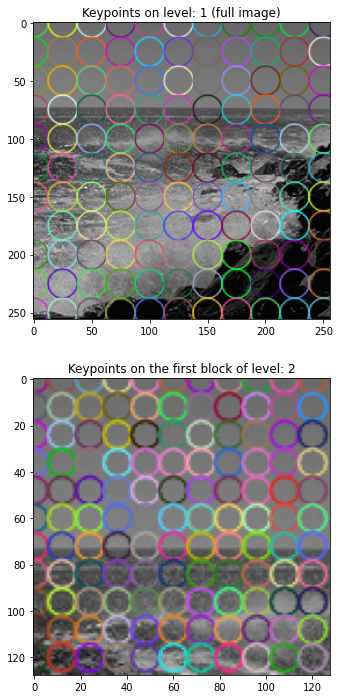

In [ ]:
example_path = filepath+"/MIT_split/test/coast/bea20.jpg"
ima=cv2.imread(example_path)
gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

step_size = 25
print("Keypoints using spatial pyramid (vertical and horizontal split)")
print("Example using initial step_size=25, 2 levels + step_size decreases at each split")
compute_spatial_pyramid_representation(gray, 2,25, True)


### Allowing only horizontal split
Additionally, it also allows to make only horizontal splits instead of dividing the image in square blocks. This, however, did not have a great impact on the results. Since we could only try splits of one level (full image, no split) and two levels (one split), we think that results might vary further if the image could to be split using more levels than 2.


In [ ]:

print("Example using initial step_size=25, 2 levels + fixed step_size + only horizontal split")
compute_spatial_pyramid_representation(gray, 2,25, True,True);

Example using initial step_size=25, 2 levels + fixed step_size + only horizontal split


In [ ]:
fig = plot_contour(full_study, params=["max_level", "hor_only"])
fig.update_layout(title_text="Effect of doing horizontal-only splits",
                  title_font_size=20)

image.png


An issue we have come across using this method was the **memory needed to store the descriptors** (and, consequentally, the time it takes to train it). The size of the arrays we store descriptors in increases rapidly when decreasing the step-size or increasing the amount of levels. This issue has limited the parameters we used in our experiments, as either using more levels or smaller stepsizes could not be handled by our devices.

As we can see below, the best results are obtained using 2 levels with size 12 keypoints, followed by using only 1 level with size 8 keypoints. We believe that using more levels would have improved our results further, but it has not been possible to run it for the issue mentioned above.

In [ ]:
fig = plot_contour(full_study, params=["stepsize", "max_level"])
fig.update_layout(title_text="Relationship between stepsize (keypoint size) and number of levels",
                  title_font_size=20)

image.png


## SVM
The experiments have been carried out using both KNN or SVM as classifiers, varying the kernels between poly, linear, in the case of the latter. Although we had defined a histogram intersection function to use as a kernel, we have not been able to set it as a parameter in optuna, hence why it has been excluded for the trials.

The kernel that obtained the best performance has been rbf, a kernel often used when data is linearly inseparable.

There has not been much of a difference using SVM or KNN. In fact, a lot of trials ended up getting better results using KNN instead.  This could be because our data is linearly separable, so both KNN and SVM get good results on it. However, in the case of SVM, as it can be seen below, using non-linear kernels significantly improved the performance, so it is not likely to be the case. The fact that we were not able to use histogram intersection as a kernel might caused to get worse results compared to KNN as we may not be using the best kernel for SVM and our data.

In [ ]:
fig = plot_slice(full_study, params=[ "classifier"])
fig.update_layout(title_text="KNN/SVM trial results")


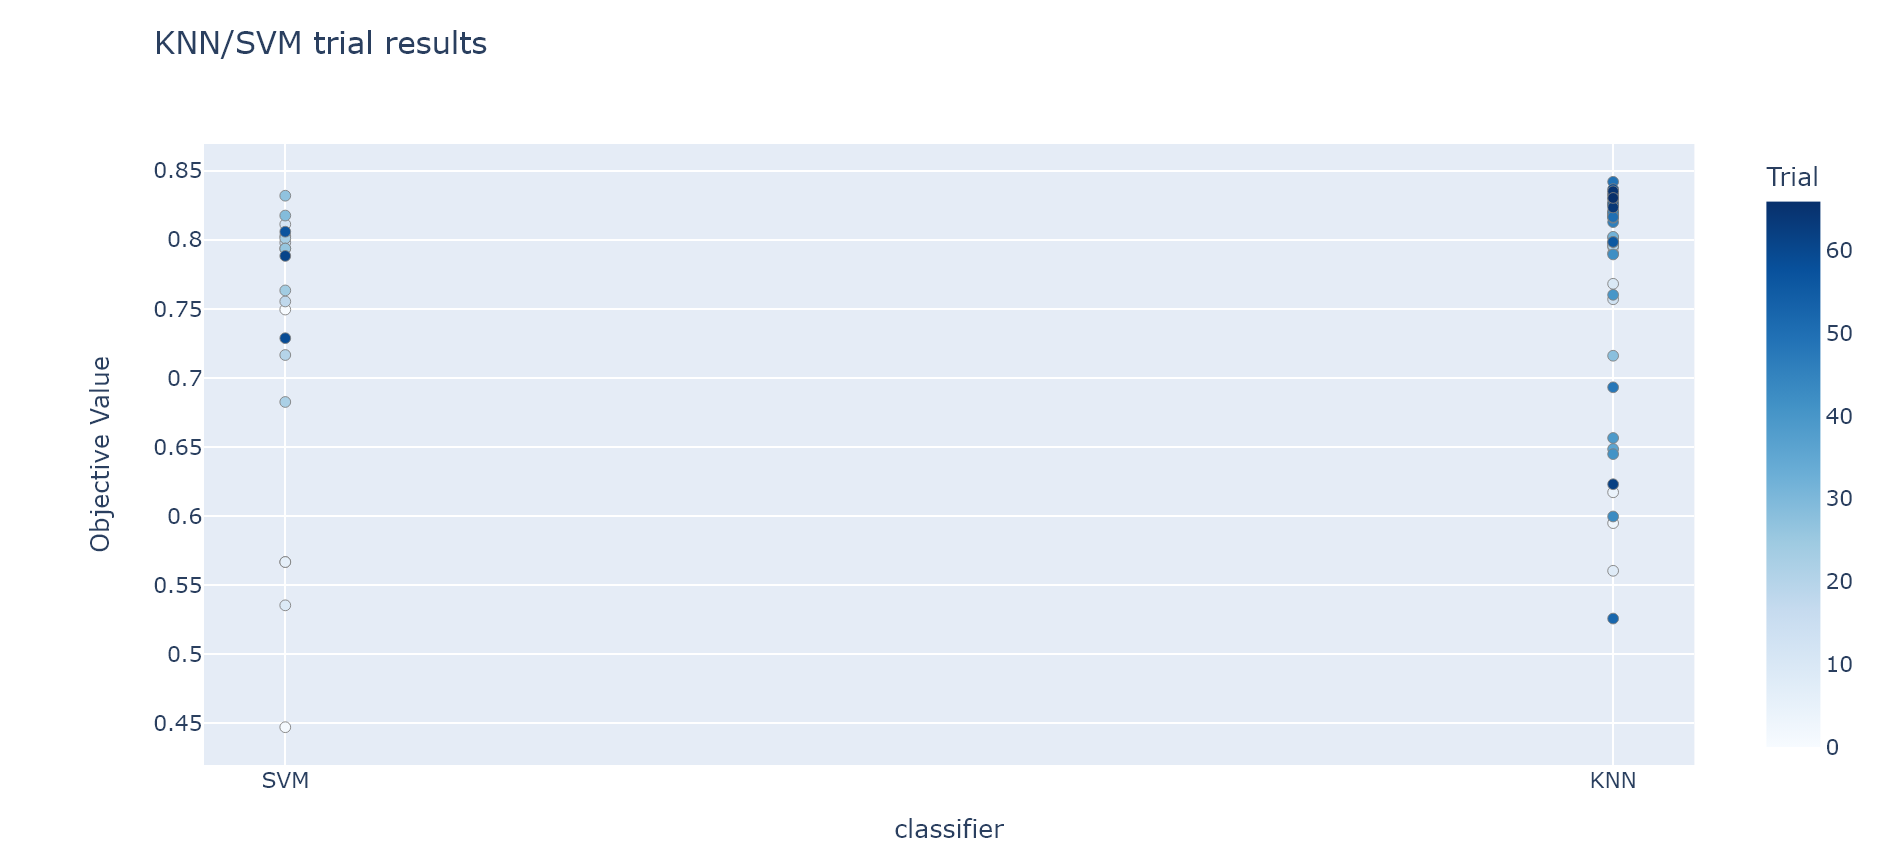

In [ ]:
fig = plot_slice(full_study, params=[ "kernel"])
fig.update_layout(title_text="Trial results varying SVM kernels")

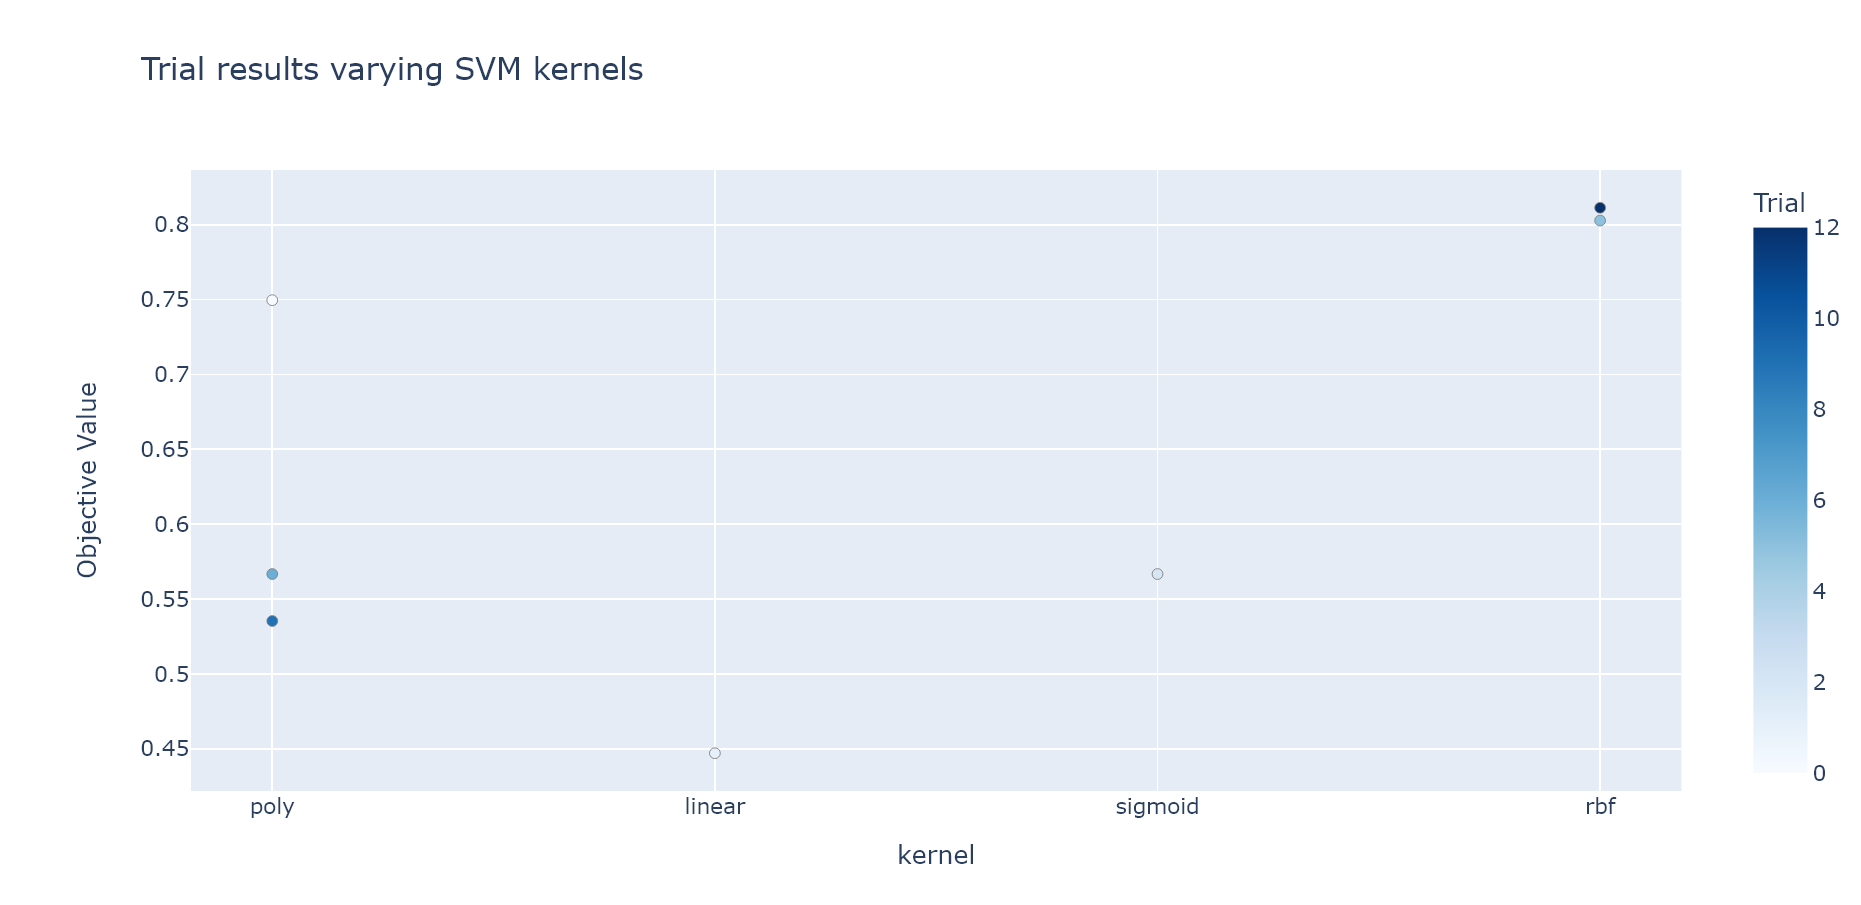


## Fisher vectors
We tried to optimize the performance of our classifier by implementing Fisher vectors in the following function:



In [ ]:
def fisher_vector(xx, gmm):
    """
    From https://gist.github.com/danoneata/9927923/
    Computes the Fisher vector on a set of descriptors.
    Parameters
    ----------
    xx: array_like, shape (N, D) or (D, )
        The set of descriptors
    gmm: instance of sklearn mixture.GMM object
        Gauassian mixture model of the descriptors.
    """
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(xx)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covariances_
        + 2 * Q_xx * gmm.means_)

    # Merge derivatives into a vector.
    return np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))


  

The results obtained by using Fisher vectors are shown in the following table. The hyperparameters used are: 
- 'classifier': 'KNN',
- 'codebook': 256,
- 'hor_only': True,
- 'knn_metric': 'euclidean',
- 'max_level': 2,
- 'n_components': 7,
- 'n_neighbours': 30,
- 'norm': 'power',
- 'octaves': 20,
- 'stepsize': 12,
- 'technique': 'LDA'


| Parameters  |Accuracy | 
|------------|---------- | 
|  codebook=16 | 79.677 | 
|  codebook=32 |  79.925 |
|  codebook=64  | 78.438 |
|  codebook=128 | 74.349 | 

The parameter vary_size which modifies the size_step parameter in each scale of the pyramid has been disabled due to the fact that each trial takes about 2 hours to complete. Because of this, we have not added into the Optuna study the possibility to use Fisher vectors.
In the table we can see that implementing Fisher vectors doesn't seem to improve the accuracy significantly (in fact, the performance is diminished). 
 


## Parameters overview
After optimising the parameters of the classifier on Optuna, the trial with best results has the following parameters:


In [ ]:
import pprint

print("Best parameters: ")
pprint.pprint(full_study.best_params)
print()
print("Value: " + str(full_study.best_value) )

Best parameters: 
{'classifier': 'KNN',
 'codebook': 256,
 'hor_only': True,
 'knn_metric': 'euclidean',
 'max_level': 2,
 'n_components': 7,
 'n_neighbours': 30,
 'norm': 'power',
 'octaves': 20,
 'stepsize': 12,
 'technique': 'LDA'}

Value: 0.8420932332524409




The results have not improved significantly compared to the previous week (~74% accuracy vs 84% accuracy), although this is because the parameters we have introduced do not have as much weight as some of the parameters established last week (dimensionality reduction, codebook sizes). Furthermore, adding multiple levels on the histograms to preserve local information has not affected the performance as much as we expected to.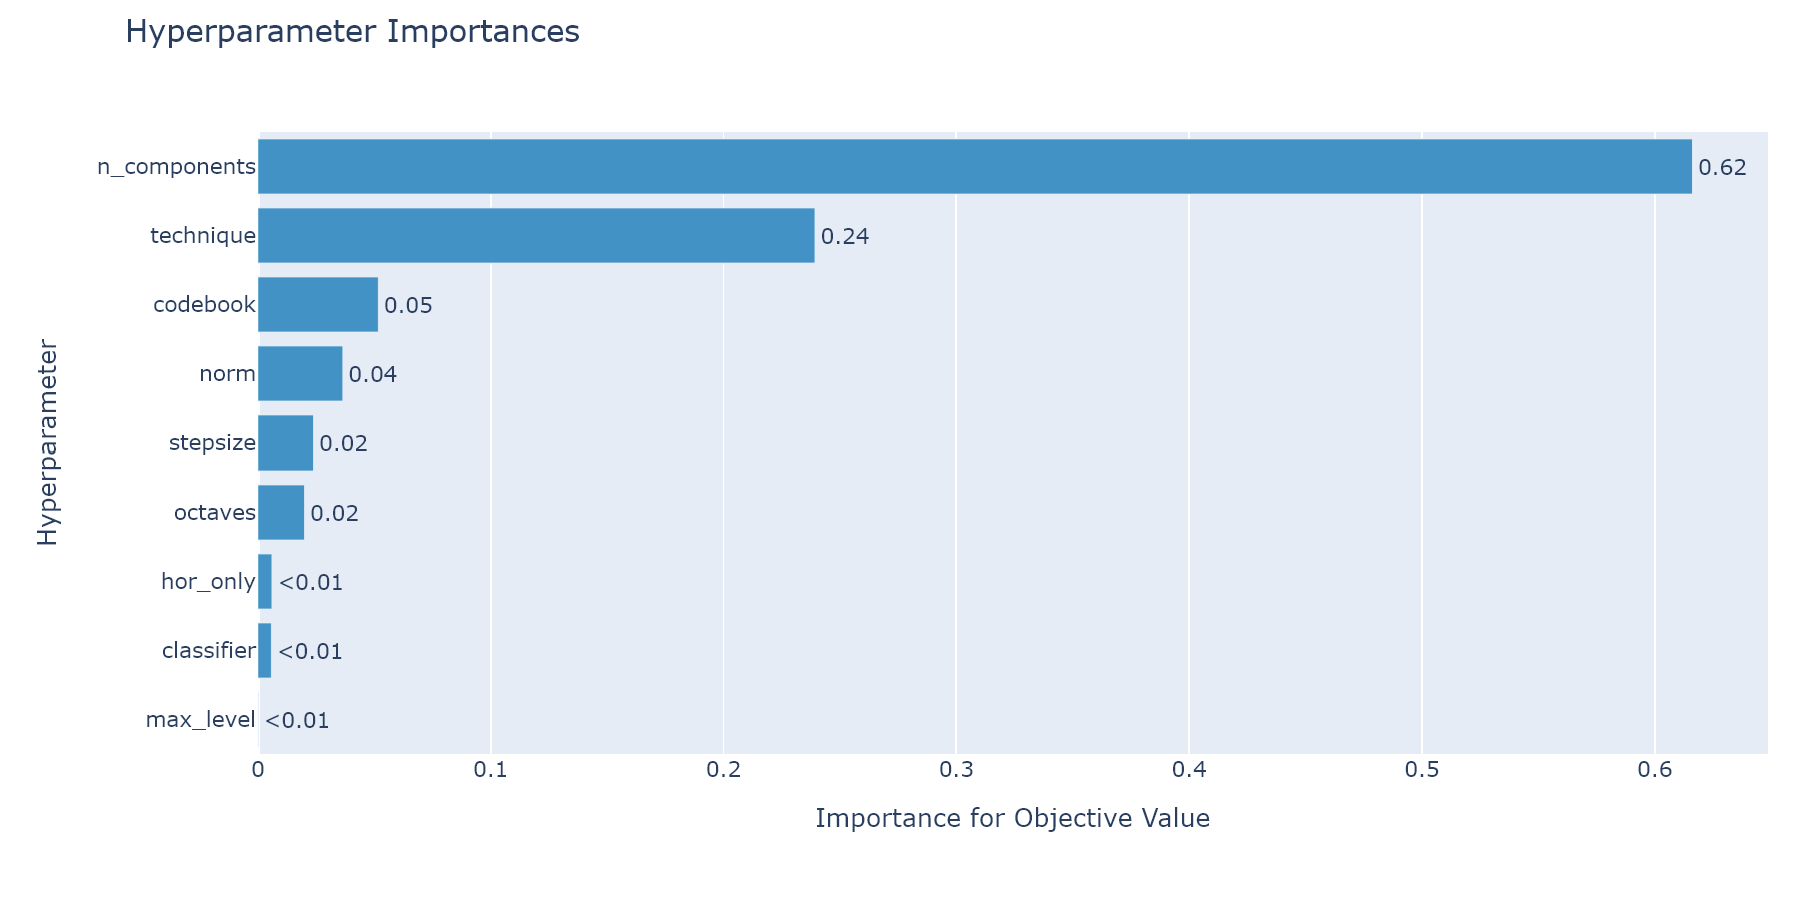

In [ ]:
fig = plot_param_importances(full_study)
fig.show()

# **Test results**

We observe that by using the parameters obtained cross-validating with the train dataset, the performance improves slightly to 0.84 with respect to the results obtained past week. The result on the test data is only 0.002 under the results on train data, meaning that our implementation generalises well.

In [ ]:
study = optuna.load_study(study_name="hkjlhklg-study", storage="sqlite:///final60.db")

trial = study.best_trial

X_train = get_descriptors(trial, train_images_filenames)
y_train = train_labels
X_test = get_descriptors(trial, test_images_filenames)
y_test = test_labels


visual_words_train, visual_words_validate = compute_visual_words(trial, X_train, X_test) 
X_train_DR, X_validate_DR = dimensionality_reduction(trial, visual_words_train, y_train, visual_words_validate)
pred_validate = fit_data(trial, X_train_DR, y_train, X_validate_DR)

val_score = accuracy_score(y_test, pred_validate)
print(f"Accuracy is {val_score}")

compute visual words
fit data
Accuracy is 0.8401486988847584



# **Conclusions**

This assignment has shown us how to code and enhance a classifier using BoW, but it has also shown us the limitations of it. Our current results are still under 90% accuracy and tuning the parameters further requires an amount of memory that would become unfeasible with larger datasets. 